In [0]:
#https://www.tensorflow.org/tutorials/customization/custom_training

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


It seems that in this and the gradient tutorial, we are building networks "from scratch", instead of using the `keras API`

#Variables

Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, must have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state, which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:

In [3]:
# Using Python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)


tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow has stateful operations built-in, and these are often easier than using low-level Python representations for your state. Use `tf.Variable` to represent weights in a model.

A `tf.Variable` object stores a value and implicitly reads from this stored value. There are operations (`tf.assign_sub`, `tf.scatter_update`, etc.) that manipulate the value stored in a TensorFlow variable.

In [0]:
#basically just creating and manipulating a variable
v = tf.Variable(1.0)
# Use Python's `assert` as a debugging statement to test the condition
assert v.numpy() == 1.0

# Reassign the value `v`
v.assign(3.0) #note, if instead of assign we use v = 3, it gives error because it is not a numpy object
assert v.numpy() == 3.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0


Computations using `tf.Variable` are automatically traced when computing gradients. For variables that represent embeddings, TensorFlow will do sparse updates by default, which are more computation and memory efficient.

A `tf.Variable` is also a way to show a reader of your code that a piece of state is mutable.

#Fit a linear model

Let's use the concepts you have learned so far—Tensor, Variable, and GradientTape—to build and train a simple model. This typically involves a few steps:

    Define the model.
    Define a loss function.
    Obtain training data.
    Run through the training data and use an "optimizer" to adjust the variables to fit the data.

Here, you'll create a simple linear model, `f(x) = x * W + b`, which has two variables: `W` (weights) and `b` (bias). You'll synthesize data such that a well trained model would have W = 3.0 and b = 2.0.

#Define the model

Let's define a simple class to encapsulate the variables and the computation:

In [0]:
#super simple linear model
class Model(object):
  def __init__(self):
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0


#Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Let's use the standard L2 loss, also known as the least square errors:

In [0]:
#least square error model
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))


#Obtain training data

First, synthesize the training data by adding random Gaussian (Normal) noise to the inputs:

In [0]:
#the values we are supposed to get
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

#This creates 1000 inputs and noise values (from 0 to 1)
#the values are distributed normally, which means there will be more values around the average (0),
inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise #

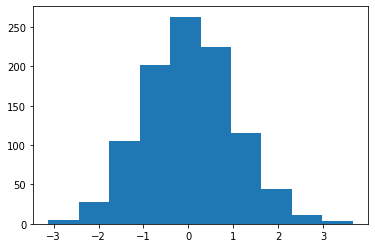

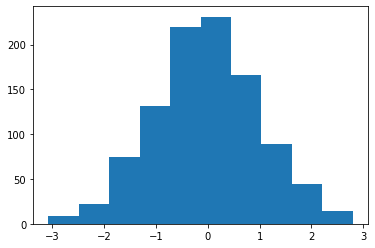

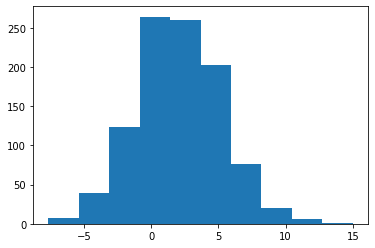

In [32]:
_ = plt.hist(inputs)
plt.show()
_ = plt.hist(noise)
plt.show()
_ = plt.hist(outputs)
plt.show()

Before training the model, visualize the loss value by plotting the model's predictions in red and the training data in blue:

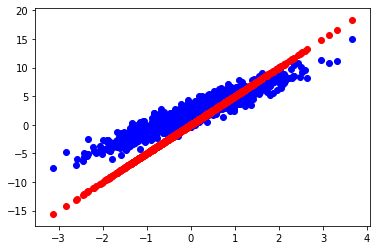

Current loss: 8.831619


In [34]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r') #passing the data to the model it gives the red line (linear function)
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())
#now we will train it to improve the fit


#Define a training loop

With the network and training data, train the model using gradient descent to update the weights variable (`W`) and the bias variable (`b`) to reduce the loss. There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`—our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assig`n and `tf.sub`):

In [0]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs) #loss is the least square error
  dW, db = t.gradient(current_loss, [model.W, model.b]) #the gradient between the current loss and the model variables.
  model.W.assign_sub(learning_rate * dW) #getting the gradient * learning_rate is the new W
  model.b.assign_sub(learning_rate * db)


Finally, let's repeatedly run through the training data and see how W and b evolve.

Epoch  0: W=5.00 b=0.00, loss=8.83162
Epoch  3: W=4.04 b=0.95, loss=3.15164
Epoch  6: W=3.53 b=1.45, loss=1.60019
Epoch  9: W=3.27 b=1.71, loss=1.17642
Epoch 12: W=3.13 b=1.84, loss=1.06067
Epoch 15: W=3.06 b=1.91, loss=1.02905
Epoch 18: W=3.02 b=1.95, loss=1.02041
Epoch 21: W=3.00 b=1.97, loss=1.01805


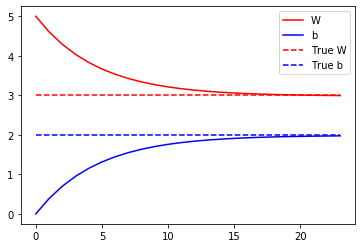

In [41]:
model = Model() #our simple linear model

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(24)
for epoch in epochs:
  #collecting the current value of the variables
  Ws.append(model.W.numpy()) 
  bs.append(model.b.numpy())
  #getting the loss, the real values vs the predicted values
  current_loss = loss(model(inputs), outputs)
  #train the model once, and update its weights
  train(model, inputs, outputs, learning_rate=0.1)
  if(epoch %3 == 0):
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
          (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


#Conclusion
This tutorial used `tf.Variable` to build and train a simple linear model.

In practice, the high-level APIs—such as `tf.keras`—are much more convenient to build neural networks. `tf.keras` provides higher level building blocks (called "layers"), utilities to save and restore state, a suite of loss functions, a suite of optimization strategies, and more. Read the TensorFlow Keras guide to learn more.